# Objective

https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview/description

We are provided with a daily sales dataset and we are required to forecast the sales of the next month.

For each id in the test set, we must predict a total number of sales

We need to forecast the items to be sold the next month which is November 2015. For the products and shops that are in the test.csv. 

Ideally we would like to make a prediction per month, day of week, shop and product, so 1 level of granularity deeper.


# Set Actions

In [1]:
LoadInitialData = True
PrepareData = True
ClipData = False
SaveData = True   # Only works if PrepareData = True
LoadPrepData = True
Calibrate = True
SampleDivision = 10 #reduce dataset for hyperparameter tuning
Caliteration = 1000
RunCatBoost = True
Catiterations=1000
SaveCatBoost = True
MonthstoRemove = 11 # this will depend on your longer lag python starts at 0 so 11 is 12 months


# Libraries

In [2]:
import os
from datetime import datetime
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd

from itertools import product
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.model_selection import train_test_split
import catboost
from catboost import CatBoostRegressor, Pool

import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error

import shap
shap.initjs()

import time
import calendar

import sys
import gc
import pickle
sys.version_info

Using TensorFlow backend.


sys.version_info(major=3, minor=7, micro=3, releaselevel='final', serial=0)

# Functions creation

In [3]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0

def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

# Extract Transform Load (ETL)

The data will be directly loaded from the Kaggle website ( please review requirements above). 
The data is loaded as a zipfile and will then be extracted as csv files. 
The CSV files are then load into the Notebook with pandas and we instructs datatype and transform data data in classic datetime format

## Import Data

In [4]:
if LoadInitialData == False:
    print("LoadInitialData == False")
    
else:
    # importing required modules 
    from zipfile import ZipFile 

    # specifying the zip file name 
    file_name = "competitive-data-science-predict-future-sales.zip"

    # opening the zip file in READ mode 
    with ZipFile(file_name, 'r') as zip: 
        # printing all the contents of the zip file 
        zip.printdir() 

        # extracting all the files 
        print('Extracting all the files now...') 
        zip.extractall() 
        print('Done!') 


File Name                                             Modified             Size
item_categories.csv                            2019-12-15 22:01:26         3573
items.csv                                      2019-12-15 22:01:26      1568417
sales_train.csv                                2019-12-15 22:01:28     94603866
sample_submission.csv                          2019-12-15 22:01:34      2245108
shops.csv                                      2019-12-15 22:01:34         2977
test.csv                                       2019-12-15 22:01:34      3182735
Extracting all the files now...
Done!


## Format Data

In [57]:
if PrepareData == False:
    print("LoadInitialData == False")
    
else:    
    # load unzipped csv files
    CurrentPath = os.getcwd()
    startTime = datetime.now()

    test = pd.read_csv(CurrentPath+'/test.csv'
                    , dtype={'ID': 'int32', 'shop_id': 'int32', 'item_id': 'int32'})
    print('test loaded in '+str(datetime.now() - startTime))
    startTime = datetime.now()
    cats = pd.read_csv(CurrentPath+'/item_categories.csv'
                    , dtype={'item_category_name': 'str', 'item_category_id': 'int32'})
    print('item_categories loaded in '+str(datetime.now() - startTime))
    startTime = datetime.now()
    items = pd.read_csv(CurrentPath+'/items.csv'
                    , dtype={'item_name': 'str', 'item_id': 'int32', 'item_category_id': 'int32'})
    print('items loaded in '+str(datetime.now() - startTime))
    startTime = datetime.now()
    shops = pd.read_csv(CurrentPath+'/shops.csv'
                    , dtype={'shop_name': 'str', 'shop_id': 'int32'})
    print('shops loaded in '+str(datetime.now() - startTime))
    startTime = datetime.now()
    train = pd.read_csv(CurrentPath+'/sales_train.csv'
                    , dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 
                          'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})
    train2 = train.copy(deep=True)
    print('train loaded in '+str(datetime.now() - startTime)) 

test loaded in 0:00:00.150556
item_categories loaded in 0:00:00.015069
items loaded in 0:00:00.079038
shops loaded in 0:00:00.020275
train loaded in 0:00:01.501566


In [60]:
train.head(2)
items.head(2)
cats.head(2)
shops.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1
1,03.01.2013,0,25,2552,899.0,1


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1


In [6]:
# amend date structure by controlling dates directly to avoid months/days mix up. feel free to get a coffee 
if PrepareData == False:
    print("LoadInitialData == False")
    
else: 
    startTime = datetime.now()
    date_parts = train['date'].apply(lambda d: pd.Series(int(n) for n in d.split('.')))
    date_parts.columns = ['day', 'month', 'year']
    train['date'] = pd.to_datetime(date_parts)
    print('dates computed in '+str(datetime.now() - startTime))

dates computed in 0:11:52.247146


## View all defined Variables

In [7]:
%whos

Variable             Type             Data/Info
-----------------------------------------------
Calibrate            bool             True
Caliteration         int              1000
CatBoostRegressor    type             <class 'catboost.core.CatBoostRegressor'>
Catiterations        int              1000
ClipData             bool             False
CurrentPath          str              /Users/charlesd/CourseraFinal
Dense                type             <class 'keras.layers.core.Dense'>
Dropout              type             <class 'keras.layers.core.Dropout'>
InteractiveShell     MetaHasTraits    <class 'IPython.core.inte<...>eshell.InteractiveShell'>
LSTM                 type             <class 'keras.layers.recurrent.LSTM'>
LabelEncoder         type             <class 'sklearn.preproces<...>sing.label.LabelEncoder'>
LoadInitialData      bool             True
LoadPrepData         bool             True
MinMaxScaler         type             <class 'sklearn.preprocessing.data.MinMaxScaler'>

# Exploratory Data Analysis and Features Engineering (EDA)

* dates
The dates ranges from the 2013-01-01 to 2015-10-31.I have faced issues with dates to be translated from dd.mm.yyyy to yyyy-mm-dd. The solution was to control dates directly and instruct datetime library about the date strucuture. We have check if the date block was correct and no issues were found. 


To do:

* we need to merge the dataframe to complete the sales data. The item id can help us to merge it with the item category and add this information to the main dataset. Shops and item_id data set are unfortunaltely not usable because the names are in russian. The item prices seems useless at the moment as we should forecast the number of items.

* We should look at seasonality

1. There are some outliers in the item prices and item count that we have removed from the dataset. We have filled negative prices with median. We have corrected some shops duplicates

2. The Trainset is composed by 6 columns that contains sales information about the day of sales, the month of sales, the shop, the item, the sales price and unit sold. +1 means a sale, -1 means a refund

3. The dates ranges from the 2013-01-01 to 2015-10-31 and we have data over 34 months, 60 shops and 21807 items

4. Each shop_name starts with the city name. Each category contains type and subtype in its name it was therefore possible to create subcategories and also find the type of shops and cities in the analysis. By Splitting the data we found 30 cities, 7 shop types, 20 item category types and 65 sub category types




5. By plotting the item counts, we can see there is a downward trend and a clear seasonality per month. By creatinf Day of Months and Day of weeks features we can see that there is clear monthly seasonality and day of week seasonality year by year and also reconfirm the downward trend of items. WE also see that this day of week seasonality is constant over the months except for the month of December



## Outliers management

<Figure size 720x144 with 0 Axes>

(-100, 3000)

<Figure size 720x144 with 0 Axes>

(-1.0, 338778.0)

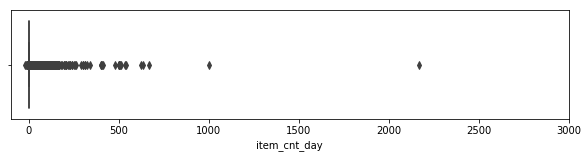

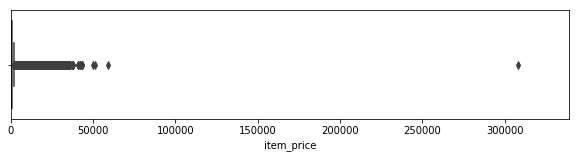

In [8]:
# find outliers
if PrepareData == False:
    print("LoadInitialData == False")
    
else:    
    plt.figure(figsize=(10,2));
    plt.xlim(-100, 3000);
    sns.boxplot(x=train.item_cnt_day);
    plt.figure(figsize=(10,2));
    plt.xlim(train.item_price.min(), train.item_price.max()*1.1);
    sns.boxplot(x=train.item_price);

In [9]:
# remove/correct outliers
if PrepareData == False:
    print("LoadInitialData == False")
    
else:      
    print("########")
    print("Outliers removed with train.item_price<100000 & train.item_cnt_day<1001")
    train = train[train.item_price<100000]
    train = train[train.item_cnt_day<1001]
    print("########")
    print("Fill negative price with median")
    median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
    train.loc[train.item_price<0, 'item_price'] = median
    print("########")
    print("Remove Shops duplicates")
    # Якутск Орджоникидзе, 56
    train.loc[train.shop_id == 0, 'shop_id'] = 57
    test.loc[test.shop_id == 0, 'shop_id'] = 57
    # Якутск ТЦ "Центральный"
    train.loc[train.shop_id == 1, 'shop_id'] = 58
    test.loc[test.shop_id == 1, 'shop_id'] = 58
    # Жуковский ул. Чкалова 39м²
    train.loc[train.shop_id == 10, 'shop_id'] = 11
    test.loc[test.shop_id == 10, 'shop_id'] = 11
    print("########")

########
Outliers removed with train.item_price<100000 & train.item_cnt_day<1001
########
Fill negative price with median
########
Remove Shops duplicates
########


## Categories, Shops and Items Exploration

In [10]:
train.head(2)
train2.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.0,1
1,2013-01-03,0,25,2552,899.0,1


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1
1,03.01.2013,0,25,2552,899.0,1


In [11]:
nmonths = len(train.date_block_num.unique())
nshops = len(train.shop_id.unique())
nitems = len(train.item_id.unique())
print("#######")
print("There are "+str(nmonths)+" months in the dataset")
print("There are "+str(nshops)+" shops in the dataset")
print("There are "+str(nitems)+" items in the dataset")

#######
There are 34 months in the dataset
There are 57 shops in the dataset
There are 21806 items in the dataset


In [12]:
cities = pd.DataFrame({'shop_id':[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
                      ,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59]
          , 'city_name':['Yakutsk','Yakutsk','Adygea', 'Balashikha','Volzhsky','Vologda','Voronezh','Voronezh'
                             ,'Voronezh','OutboundTrade','Zhukovsky','Zhukovsky','Web','Kazan','Kazan','Kaluga'
                             ,'Kolomna','Krasnoyarsk','Krasnoyarsk','Kursk','Moscow','Moscow','Moscow','Moscow','Moscow'
                             ,'Moscow','Moscow','Moscow','Moscow','Moscow','Moscow','Moscow','Moscow','Mytischi'
                             ,'NizhnyNovgorod','NizhnyNovgorod','Novosibirsk','Novosibirsk','Omsk','Rostov-on-Don'
                             ,'Rostov-on-Don','Rostov-on-Don','SanktPetersburg','SanktPetersburg','Samara','Samara'
                             ,'SergievPosad','Surgut','Tomsk','Tyumen','Tyumen','Tyumen','Ufa','Ufa','Khimki','Web'
                             ,'Chekhov','Yakutsk','Yakutsk','Yaroslavl']
                      
           , 'Shop_Type':['Shop','TC','TC','TRC','TC','TRC','Shop','TRC','TRC','Other'
                          ,'Shop','Shop','Web','TC','TC','TRC','TC','TC','TC','TC'
                          ,'Other','TC','Shop','TC','TC','TRC','TC','TC','TC','TC'
                          ,'TC','TC','TC','TRC','TRC','TRC','TRC','TC','TC','TRC'
                          ,'TRC','TC','TC','TC','TC','TC','TC','SEC','SEC','SEC'
                          ,'SC','SC','TC','TC','TC','Web','SEC','Shop','SC','SC']})

In [13]:
if PrepareData == False:
    print("LoadInitialData == False")
    
else:   
    print("########")
    print("Extract the first part of Shop Name which is City Name")
    shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
    shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
    print("########")
    print("Remove Exclamation points from some cities")
    shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
    print("########")
    print("Replace city names by labels")
    shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
    shops.loc[shops.city_code == 27, 'city_code'] = 7
    shops = pd.merge(shops, cities, on=['shop_id'], how='left')
    #shops = shops[['shop_id','city_code']]
    print("########")
    print("Split Category data into type ad subtype and replace names by labels")
    cats['split'] = cats['item_category_name'].str.split('-')
    cats['type'] = cats['split'].map(lambda x: x[0].strip())
    cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
    # if subtype is nan then type
    cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
    cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
    #cats = cats[['item_category_id','type_code', 'subtype_code']]
    print("########")
    #print("Remove Item names")
    #items.drop(['item_name'], axis=1, inplace=True)
    #print("########")

########
Extract the first part of Shop Name which is City Name
########
Remove Exclamation points from some cities
########
Replace city names by labels
########
Split Category data into type ad subtype and replace names by labels
########


In [14]:
print("There are "+str(len(shops.city_code.unique()))+" cities in the dataset")
print("There are "+str(len(shops.Shop_Type.unique()))+" shop types in the dataset")
print("There are "+str(len(cats.type.unique()))+" category types in the dataset")
print("There are "+str(len(cats.subtype.unique()))+" sub category types in the dataset")

type

There are 30 cities in the dataset
There are 7 shop types in the dataset
There are 20 category types in the dataset
There are 65 sub category types in the dataset


type

In [15]:
cats.head(2)
train.head(2)
shops.head(2)
items.head(2)

,item_category_name,item_category_id,split,type,type_code,subtype,subtype_code
0,PC - Гарнитуры/Наушники,0,"[PC , Гарнитуры/Наушники]",PC,0,Гарнитуры/Наушники,29
1,Аксессуары - PS2,1,"[Аксессуары , PS2]",Аксессуары,1,PS2,9


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.0,1
1,2013-01-03,0,25,2552,899.0,1


,shop_name,shop_id,city,city_code,city_name,Shop_Type
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,29,Yakutsk,Shop
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,29,Yakutsk,TC


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76


In [16]:

train = train.merge(items, on='item_id')
train = train.merge(shops, on='shop_id')
train = train.merge(cats, on='item_category_id')
train.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,city,city_code,city_name,Shop_Type,item_category_name,split,type,type_code,subtype,subtype_code
0,2013-01-02,0,59,22154,999.0,1,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Ярославль,30,Yaroslavl,SC,Кино - Blu-Ray,"[Кино , Blu, Ray]",Кино,11,Blu,1
1,2013-04-26,3,59,944,150.0,1,2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Ярославль,30,Yaroslavl,SC,Кино - Blu-Ray,"[Кино , Blu, Ray]",Кино,11,Blu,1


Text(0.5, 1.0, 'By city')

Text(0.5, 1.0, 'By Shop_Type')

Text(0.5, 1.0, 'item type')

Text(0.5, 1.0, 'item subtype')

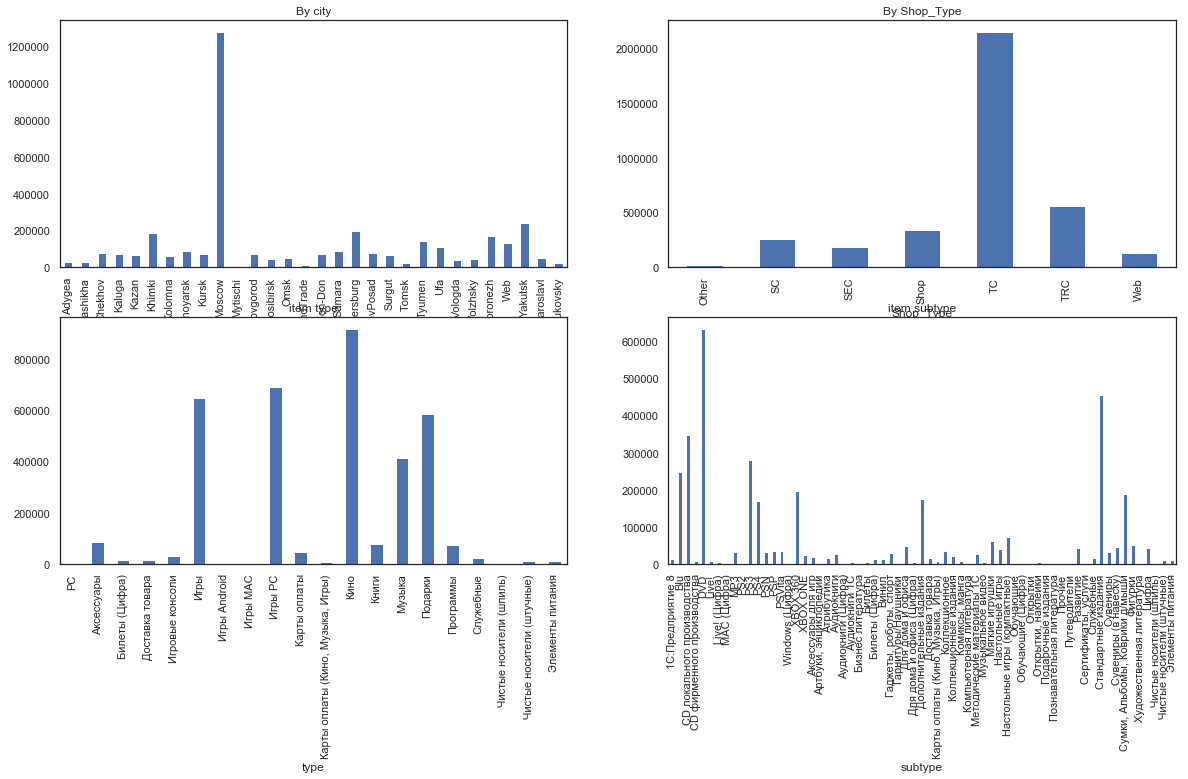

In [17]:
sns.set(style="white")
f,axes = plt.subplots(2,2,figsize=(20,10),sharex=False)
ax1 = train.groupby(['city_name'])['item_cnt_day'].sum().plot(kind='bar',ax=axes[0,0])
ax1.set_title("By city")
ax1 = train.groupby(['Shop_Type'])['item_cnt_day'].sum().plot(kind='bar',ax=axes[0,1])
ax1.set_title("By Shop_Type")
ax1 = train.groupby(['type'])['item_cnt_day'].sum().plot(kind='bar',ax=axes[1,0])
ax1.set_title("item type")
ax1 = train.groupby(['subtype'])['item_cnt_day'].sum().plot(kind='bar',ax=axes[1,1])
ax1.set_title("item subtype")

## Seasonality Exploration

Text(0.5, 1.0, 'Sum Items count per month')

Text(0.5, 1.0, 'Sum Items count per date')

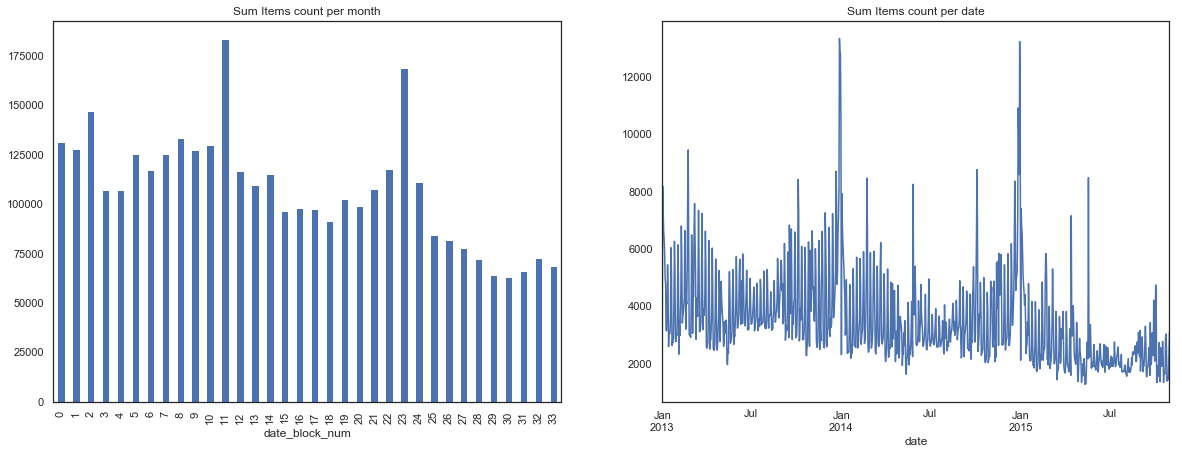

In [18]:
# check seasonality and trends
sns.set(style="white")
f,axes = plt.subplots(1,2,figsize=(20,7),sharex=False)
ax1 = train.groupby(['date_block_num'])['item_cnt_day'].sum().plot(kind='bar',ax=axes[0])
ax1.set_title("Sum Items count per month")
ax2 = train.groupby(['date'])['item_cnt_day'].sum().plot(ax=axes[1])
ax2.set_title("Sum Items count per date")

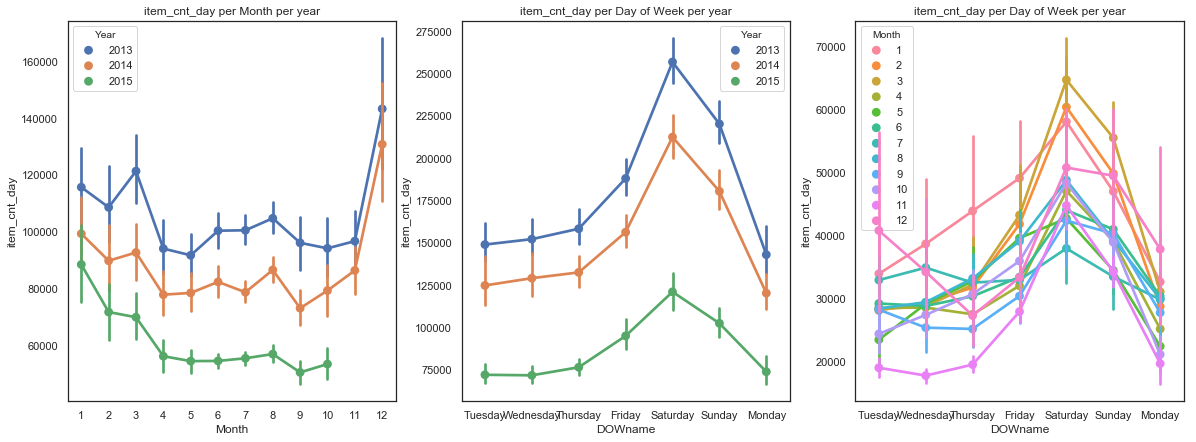

In [19]:
daycats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
# Note: Seaborn allows group by but it is much slower so not efficient
Date = train.groupby('date')[
    'item_cnt_day'].count().reset_index()
Date['Month'] = Date['date'].dt.month
Date['Year'] = Date['date'].dt.year
Date['DOWname'] = Date['date'].dt.weekday_name
sns.set(style="white")
f,axes = plt.subplots(1,3,figsize=(20,7),sharex=False)
ax1 = sns.pointplot(x="Month", y="item_cnt_day",hue="Year",estimator=sum, data=Date,ax=axes[0])
ax1.set_title("item_cnt_day per Month per year")
ax2 = sns.pointplot(x="DOWname", y="item_cnt_day",hue="Year",estimator=sum, data=Date,ax=axes[1]);
ax2.set_title("item_cnt_day per Day of Week per year");
ax2 = sns.pointplot(x="DOWname", y="item_cnt_day",hue="Month",estimator=sum, data=Date,ax=axes[2]);
ax2.set_title("item_cnt_day per Day of Week per year");

## Structure the train data and create features
The test set is composed by shop_id and item_id. We therefore need to predict the amount of items sold per shops. We should therefore structure the train set into the same way per month. We should also concatenate both shops_id and items_id from both test and train to ensure all possibilities are covered in the train matrix. Below are each steps of the preparation

1. Prepare test data
2. Create Initial empty Matrix with Month number, Shop_id, and Item_id
3. Concatenate the Matrix data with the Test data to have all shops and items in Matrix
4. Update datatypes 
5. Compute revenue of train_set
6. Structure train data like Matrix and add item count to Matrix 
7. Merge Shops, Items and Category data into Matrix 
8. Update Matrix Datatypes
9. Create Lag features for 1,3,6,12 months on items counts 
10. Compute average items count per month 
11. Compute average items count per month per shop 
12. Compute average items count per month per shop 
13. Compute average items count per month per category id 
14. Compute average items count per month per shop id per category id 
15. Compute average items count per month per shop id per type code 
16. Compute average items count per month per shop id per subtype code 
17. Compute average items count per month per city_code 
18. Compute average items count per month per item_id per city_code 
19. Compute average items count per month per type_code 
20. Compute average items count per month per subtype_code 
21. Compute average items price 
22. Compute average items price per month 
23. Add price lag per month
24. Drop lag features 
25. Compute revenue per shop per month 
26. Compute revenue per shop 
27. Number of days in Month and days of week 
28. Item shop last sale 
29. Item last sale 
30. Item shop first sale 
31. Item first sale

In [20]:
shops = shops[['shop_id','city_code']]
cats = cats[['item_category_id','type_code', 'subtype_code']]
items.drop(['item_name'], axis=1, inplace=True)

In [21]:
if PrepareData == False:
    print("LoadInitialData == False")
else:
    ts = time.time()
    print("########")
    print("1. Prepare test data")
    test['date_block_num'] = 34
    test['date_block_num'] = test['date_block_num'].astype(np.int8)
    test['shop_id'] = test['shop_id'].astype(np.int8)
    test['item_id'] = test['item_id'].astype(np.int16)
    
    print("########")
    print("2. Create Initial empty Matrix with Month number, Shop_id, and Item_id")
    matrix = []
    cols = ['date_block_num','shop_id','item_id']
    for i in range(34):
        sales = train[train.date_block_num==i]
        matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    #Stack arrays in sequence vertically (row wise).
    matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
    
    print("########")
    print("3. Concatenate the Matrix data with the Test data to have all shops and items in Matrix")
    matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
    matrix.fillna(0, inplace=True) # 34 month
    
    print("########")
    print("4. Update datatypes")
    matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
    matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
    matrix['item_id'] = matrix['item_id'].astype(np.int16)
    
    print("########")
    print("Matrix tail:")
    matrix.tail(1)
    
    print("########")
    print("5. Compute revenue of train_set = train['item_price'] *  train['item_cnt_day']")
    train['revenue'] = train['item_price'] *  train['item_cnt_day']
    
    print("########")
    print("6. Structure train data like Matrix and add item count to Matrix")
    group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
    group.columns = ['item_cnt_month']
    group.reset_index(inplace=True)
    matrix = pd.merge(matrix, group, on=cols, how='left')
    if ClipData == False:
        print("ClipData == False")
        matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                    .fillna(0)
                                    #.clip(0,20) # NB clip target here Given an interval, values outside the interval are clipped to the interval edges. For example, if an interval of [0, 1] is specified, values smaller than 0 become 0, and values larger than 1 become 1.
                                    .astype(np.float32))
    else:
        print("ClipData == True")
        matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                    .fillna(0)
                                    .clip(0,20) # NB clip target here Given an interval, values outside the interval are clipped to the interval edges. For example, if an interval of [0, 1] is specified, values smaller than 0 become 0, and values larger than 1 become 1.
                                    .astype(np.float32))
    
    print("Matrix head:")
    matrix.tail(1)
    
    print("########")
    print("7. Merge Shops, Items and Category data into Matrix")
    matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
    matrix = pd.merge(matrix, items, on=['item_id'], how='left')
    matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
    matrix.tail(1)
    
    print("########")
    print("8. Update Matrix Datatypes")
    matrix['city_code'] = matrix['city_code'].astype(np.int8)
    matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
    matrix['type_code'] = matrix['type_code'].astype(np.int8)
    matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
    
    print("########")
    print("9. Create Lag features for 1,3,6,12 months on items counts")
    matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
    matrix.tail(1)
    
    print("########")    
    print("10.Compute average items count per month")
    group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
    group.columns = [ 'date_avg_item_cnt' ]
    group.reset_index(inplace=True)
    matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
    matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float32)
    matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
    matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)
    matrix.tail(1)
    
    print("########")  
    print("11. Compute average items count per month per shop")
    group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
    group.columns = [ 'date_item_avg_item_cnt' ]
    group.reset_index(inplace=True)
    matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
    matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float32)
    matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
    matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
    matrix.tail(1)
    
    print("########")
    print("12. Compute average items count per month per shop")
    group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
    group.columns = [ 'date_shop_avg_item_cnt' ]
    group.reset_index(inplace=True)
    matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
    matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float32)
    matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
    matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
    matrix.tail(1)
    
    print("########")
    print("13. Compute average items count per month per category id")    
    group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
    group.columns = [ 'date_cat_avg_item_cnt' ]
    group.reset_index(inplace=True)
    matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
    matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float32)
    matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
    matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)
    matrix.tail(1)
    
    print("########")
    print("14. Compute average items count per month per shop id per category id")        
    group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
    group.columns = ['date_shop_cat_avg_item_cnt']
    group.reset_index(inplace=True)
    matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
    matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float32)
    matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
    matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
    matrix.tail(1)
    
    print("########")
    print("15. Compute average items count per month per shop id per type code")  
    group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
    group.columns = ['date_shop_type_avg_item_cnt']
    group.reset_index(inplace=True)
    matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
    matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float32)
    matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
    matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)
    matrix.tail(1)
    
    print("########")
    print("16. Compute average items count per month per shop id per subtype code")    
    group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
    group.columns = ['date_shop_subtype_avg_item_cnt']
    group.reset_index(inplace=True)
    matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
    matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float32)
    matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
    matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
    matrix.tail(1)
    
    print("########")
    print("17. Compute average items count per month per city_code")     
    group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
    group.columns = [ 'date_city_avg_item_cnt' ]
    group.reset_index(inplace=True)
    matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
    matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float32)
    matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
    matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
    matrix.tail(1)
    
    print("########")
    print("18. Compute average items count per month per item_id per city_code")    
    group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
    group.columns = [ 'date_item_city_avg_item_cnt' ]
    group.reset_index(inplace=True)
    matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
    matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float32)
    matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
    matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
    matrix.tail(1)
    
    print("########")
    print("19. Compute average items count per month per type_code")      
    group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
    group.columns = [ 'date_type_avg_item_cnt' ]
    group.reset_index(inplace=True)
    matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
    matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float32)
    matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
    matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)
    matrix.tail(1)
    
    print("########")
    print("20. Compute average items count per month per subtype_code")      
    group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
    group.columns = [ 'date_subtype_avg_item_cnt' ]
    group.reset_index(inplace=True)
    matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
    matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float32)
    matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
    matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)
    matrix.tail(1)
    
    print("########")
    print("21. Compute average items price")  
    group = train.groupby(['item_id']).agg({'item_price': ['mean']})
    group.columns = ['item_avg_item_price']
    group.reset_index(inplace=True)
    matrix = pd.merge(matrix, group, on=['item_id'], how='left')
    matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float32)
    matrix.shape
    matrix.tail(1)
    
    print("########")
    print("22. Compute average items price per month") 
    group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
    group.columns = ['date_item_avg_item_price']
    group.reset_index(inplace=True)
    matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
    matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float32)
    matrix.tail(1)
    
    print("########")
    print("23. Add price lag per month") 
    lags = [1,2,3,4,5,6]
    matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')
    
    for i in lags:
        matrix['delta_price_lag_'+str(i)] = \
            (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

    matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
    matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float32)
    matrix['delta_price_lag'].fillna(0, inplace=True)
    
    print("########")
    print("24. Drop lag features") 
    features_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
    
    for i in lags:
        features_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
        features_to_drop += ['delta_price_lag_'+str(i)]

    matrix.drop(features_to_drop, axis=1, inplace=True)
    matrix.tail(1)    
    
    print("########")
    print("25. Compute revenue per shop per month") 
    group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
    group.columns = ['date_shop_revenue']
    group.reset_index(inplace=True)
    matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
    matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)
    matrix.tail(1)
    
    print("########")
    print("26. Compute revenue per shop")
    group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
    group.columns = ['shop_avg_revenue']
    group.reset_index(inplace=True)
    matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
    matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)
    matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
    matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float32)
    matrix = lag_feature(matrix, [1], 'delta_revenue')
    matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
    matrix.tail(1)
    
    print("########")
    print("27. Number of days in Month and days of week")   
    datedata = pd.DataFrame(train2.date.unique(), columns=['date'])
    datedata = datedata.append({'date': '11.11.2015'}, ignore_index=True)
    date_parts = datedata['date'].apply(lambda d: pd.Series(int(n) for n in d.split('.')))
    date_parts.columns = ['day', 'month', 'year']
    date_parts['date'] = pd.to_datetime(date_parts)
    date_parts['daysinmonth'] = date_parts['date'].dt.daysinmonth
    date_parts['YYYYMM'] = date_parts['date'].map(lambda x: 100*x.year + x.month)
    date_parts = date_parts[~date_parts['YYYYMM'].duplicated(keep="first")]
    date_parts = date_parts.drop(['day','date','YYYYMM'], axis = 1).reset_index(drop=True)
    date_parts['Monday'] = date_parts.apply(lambda x: len([1 for i in calendar.monthcalendar(x['year'], x['month']) if i[0] != 0]), axis=1)
    date_parts['Tuesday'] = date_parts.apply(lambda x: len([1 for i in calendar.monthcalendar(x['year'], x['month']) if i[1] != 0]), axis=1)
    date_parts['Wednesday'] = date_parts.apply(lambda x: len([1 for i in calendar.monthcalendar(x['year'], x['month']) if i[2] != 0]), axis=1)
    date_parts['Thursday'] = date_parts.apply(lambda x: len([1 for i in calendar.monthcalendar(x['year'], x['month']) if i[3] != 0]), axis=1)
    date_parts['Friday'] = date_parts.apply(lambda x: len([1 for i in calendar.monthcalendar(x['year'], x['month']) if i[4] != 0]), axis=1)
    date_parts['Saturday'] = date_parts.apply(lambda x: len([1 for i in calendar.monthcalendar(x['year'], x['month']) if i[5] != 0]), axis=1)
    date_parts['Sunday'] = date_parts.apply(lambda x: len([1 for i in calendar.monthcalendar(x['year'], x['month']) if i[6] != 0]), axis=1)
    date_parts['date_block_num'] = date_parts.index
    matrix = pd.merge(matrix, date_parts, on=['date_block_num'], how='left')
    matrix.tail(1)
    
    print("########")
    print("28. Item shop last sale") 
    cache = {}
    matrix['item_shop_last_sale'] = -1
    matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
    
    for idx, row in matrix.iterrows():    
        key = str(row.item_id)+' '+str(row.shop_id)
        if key not in cache:
            if row.item_cnt_month!=0:
                cache[key] = row.date_block_num
        else:
            last_date_block_num = cache[key]
            matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num 
    matrix.tail(1)    
    
    print("########")
    print("29. Item last sale") 
    cache = {}
    matrix['item_last_sale'] = -1
    matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
    
    for idx, row in matrix.iterrows():    
        key = row.item_id
        if key not in cache:
            if row.item_cnt_month!=0:
                cache[key] = row.date_block_num
        else:
            last_date_block_num = cache[key]
            if row.date_block_num>last_date_block_num:
                matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
                cache[key] = row.date_block_num         
    time.time() - ts
    matrix.tail(1)   
    
    print("########")
    print("30. Item shop first sale") 
    matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
    matrix.tail(1)
    
    print("########")
    print("31. Item first sale") 
    matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')
    matrix.tail(1)
    print("########")
    print("（＾▽＾）／  ＼（＾▽＾）")
    print("########")
    print("It took "+ str((int(time.time() - ts)/60))+" minutes to run")

########
1. Prepare test data
########
2. Create Initial empty Matrix with Month number, Shop_id, and Item_id
########
3. Concatenate the Matrix data with the Test data to have all shops and items in Matrix
########
4. Update datatypes
########
Matrix tail:


,date_block_num,shop_id,item_id,ID
11128003,34,45,969,214199.0


########
5. Compute revenue of train_set = train['item_price'] *  train['item_cnt_day']
########
6. Structure train data like Matrix and add item count to Matrix
ClipData == False
Matrix head:


,date_block_num,shop_id,item_id,ID,item_cnt_month
11128003,34,45,969,214199.0,0.0


########
7. Merge Shops, Items and Category data into Matrix


,date_block_num,shop_id,item_id,ID,item_cnt_month,city_code,item_category_id,type_code,subtype_code
11128003,34,45,969,214199.0,0.0,20,37,11,1


########
8. Update Matrix Datatypes
########
9. Create Lag features for 1,3,6,12 months on items counts


,date_block_num,shop_id,item_id,ID,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
11128003,34,45,969,214199.0,0.0,20,37,11,1,0.0,0.0,0.0,0.0,0.0


########
10.Compute average items count per month


,date_block_num,shop_id,item_id,ID,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1
11128003,34,45,969,214199.0,0.0,20,37,11,1,0.0,0.0,0.0,0.0,0.0,0.289232


########
11. Compute average items count per month per shop


,date_block_num,shop_id,item_id,ID,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12
11128003,34,45,969,214199.0,0.0,20,37,11,1,0.0,0.0,0.0,0.0,0.0,0.289232,0.068182,0.116279,0.02381,0.068182,0.12


########
12. Compute average items count per month per shop


,date_block_num,shop_id,item_id,ID,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,...,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12
11128003,34,45,969,214199.0,0.0,20,37,11,1,0.0,...,0.068182,0.116279,0.02381,0.068182,0.12,0.129688,0.128614,0.138998,0.144236,0.19788


########
13. Compute average items count per month per category id


,date_block_num,shop_id,item_id,ID,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,...,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1
11128003,34,45,969,214199.0,0.0,20,37,11,1,0.0,...,0.116279,0.02381,0.068182,0.12,0.129688,0.128614,0.138998,0.144236,0.19788,0.26295


########
14. Compute average items count per month per shop id per category id


,date_block_num,shop_id,item_id,ID,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,...,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1
11128003,34,45,969,214199.0,0.0,20,37,11,1,0.0,...,0.02381,0.068182,0.12,0.129688,0.128614,0.138998,0.144236,0.19788,0.26295,0.128205


########
15. Compute average items count per month per shop id per type code


,date_block_num,shop_id,item_id,ID,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,...,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1
11128003,34,45,969,214199.0,0.0,20,37,11,1,0.0,...,0.068182,0.12,0.129688,0.128614,0.138998,0.144236,0.19788,0.26295,0.128205,0.097021


########
16. Compute average items count per month per shop id per subtype code


,date_block_num,shop_id,item_id,ID,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,...,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1
11128003,34,45,969,214199.0,0.0,20,37,11,1,0.0,...,0.12,0.129688,0.128614,0.138998,0.144236,0.19788,0.26295,0.128205,0.097021,0.126338


########
17. Compute average items count per month per city_code


,date_block_num,shop_id,item_id,ID,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,...,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1
11128003,34,45,969,214199.0,0.0,20,37,11,1,0.0,...,0.129688,0.128614,0.138998,0.144236,0.19788,0.26295,0.128205,0.097021,0.126338,0.1368


########
18. Compute average items count per month per item_id per city_code


,date_block_num,shop_id,item_id,ID,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,...,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1
11128003,34,45,969,214199.0,0.0,20,37,11,1,0.0,...,0.128614,0.138998,0.144236,0.19788,0.26295,0.128205,0.097021,0.126338,0.1368,0.5


########
19. Compute average items count per month per type_code


,date_block_num,shop_id,item_id,ID,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,...,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1
11128003,34,45,969,214199.0,0.0,20,37,11,1,0.0,...,0.138998,0.144236,0.19788,0.26295,0.128205,0.097021,0.126338,0.1368,0.5,0.226283


########
20. Compute average items count per month per subtype_code


,date_block_num,shop_id,item_id,ID,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,...,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1
11128003,34,45,969,214199.0,0.0,20,37,11,1,0.0,...,0.144236,0.19788,0.26295,0.128205,0.097021,0.126338,0.1368,0.5,0.226283,0.245474


########
21. Compute average items price


(11128004, 34)

,date_block_num,shop_id,item_id,ID,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,...,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,item_avg_item_price
11128003,34,45,969,214199.0,0.0,20,37,11,1,0.0,...,0.19788,0.26295,0.128205,0.097021,0.126338,0.1368,0.5,0.226283,0.245474,502.297058


########
22. Compute average items price per month


,date_block_num,shop_id,item_id,ID,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,...,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,item_avg_item_price,date_item_avg_item_price
11128003,34,45,969,214199.0,0.0,20,37,11,1,0.0,...,0.26295,0.128205,0.097021,0.126338,0.1368,0.5,0.226283,0.245474,502.297058,NaN


########
23. Add price lag per month
########
24. Drop lag features


,date_block_num,shop_id,item_id,ID,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,...,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag
11128003,34,45,969,214199.0,0.0,20,37,11,1,0.0,...,0.19788,0.26295,0.128205,0.097021,0.126338,0.1368,0.5,0.226283,0.245474,-0.605811


########
25. Compute revenue per shop per month


,date_block_num,shop_id,item_id,ID,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,...,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,date_shop_revenue
11128003,34,45,969,214199.0,0.0,20,37,11,1,0.0,...,0.26295,0.128205,0.097021,0.126338,0.1368,0.5,0.226283,0.245474,-0.605811,NaN


########
26. Compute revenue per shop


,date_block_num,shop_id,item_id,ID,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,...,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1
11128003,34,45,969,214199.0,0.0,20,37,11,1,0.0,...,0.26295,0.128205,0.097021,0.126338,0.1368,0.5,0.226283,0.245474,-0.605811,-0.290037


########
27. Number of days in Month and days of week


,date_block_num,shop_id,item_id,ID,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,...,month,year,daysinmonth,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
11128003,34,45,969,214199.0,0.0,20,37,11,1,0.0,...,11,2015,30,5,4,4,4,4,4,5


########
28. Item shop last sale


,date_block_num,shop_id,item_id,ID,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,...,year,daysinmonth,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,item_shop_last_sale
11128003,34,45,969,214199.0,0.0,20,37,11,1,0.0,...,2015,30,5,4,4,4,4,4,5,1


########
29. Item last sale


2539.13778090477

,date_block_num,shop_id,item_id,ID,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,...,daysinmonth,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,item_shop_last_sale,item_last_sale
11128003,34,45,969,214199.0,0.0,20,37,11,1,0.0,...,30,5,4,4,4,4,4,5,1,-1


########
30. Item shop first sale


,date_block_num,shop_id,item_id,ID,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,...,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,item_shop_last_sale,item_last_sale,item_shop_first_sale
11128003,34,45,969,214199.0,0.0,20,37,11,1,0.0,...,5,4,4,4,4,4,5,1,-1,17


########
31. Item first sale


,date_block_num,shop_id,item_id,ID,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,...,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale
11128003,34,45,969,214199.0,0.0,20,37,11,1,0.0,...,4,4,4,4,4,5,1,-1,17,17


########
（＾▽＾）／  ＼（＾▽＾）
########
It took 42.35 minutes to run


In [22]:
    datedata = pd.DataFrame(train2.date.unique(), columns=['date'])
    datedata = datedata.append({'date': '11.11.2015'}, ignore_index=True)
    date_parts = datedata['date'].apply(lambda d: pd.Series(int(n) for n in d.split('.')))
    date_parts.columns = ['day', 'month', 'year']
    date_parts['date'] = pd.to_datetime(date_parts)
    date_parts['daysinmonth'] = date_parts['date'].dt.daysinmonth
    date_parts['YYYYMM'] = date_parts['date'].map(lambda x: 100*x.year + x.month)
    date_parts = date_parts[~date_parts['YYYYMM'].duplicated(keep="first")]
    date_parts = date_parts.drop(['day','date','YYYYMM'], axis = 1).reset_index(drop=True)
    date_parts['Monday'] = date_parts.apply(lambda x: len([1 for i in calendar.monthcalendar(x['year'], x['month']) if i[0] != 0]), axis=1)
    date_parts['Tuesday'] = date_parts.apply(lambda x: len([1 for i in calendar.monthcalendar(x['year'], x['month']) if i[1] != 0]), axis=1)
    date_parts['Wednesday'] = date_parts.apply(lambda x: len([1 for i in calendar.monthcalendar(x['year'], x['month']) if i[2] != 0]), axis=1)
    date_parts['Thursday'] = date_parts.apply(lambda x: len([1 for i in calendar.monthcalendar(x['year'], x['month']) if i[3] != 0]), axis=1)
    date_parts['Friday'] = date_parts.apply(lambda x: len([1 for i in calendar.monthcalendar(x['year'], x['month']) if i[4] != 0]), axis=1)
    date_parts['Saturday'] = date_parts.apply(lambda x: len([1 for i in calendar.monthcalendar(x['year'], x['month']) if i[5] != 0]), axis=1)
    date_parts['Sunday'] = date_parts.apply(lambda x: len([1 for i in calendar.monthcalendar(x['year'], x['month']) if i[6] != 0]), axis=1)
    date_parts['date_block_num'] = date_parts.index

In [23]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)
time.time() - ts

5.897544860839844

In [24]:
# delete the datasets not needed
del cache
del group
del items
del shops
del cats
del train
del train2
del date_parts
del sales
del Date

In [25]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 0 to 11128003
Data columns (total 49 columns):
date_block_num                          int8
shop_id                                 int8
item_id                                 int16
ID                                      float64
item_cnt_month                          float32
city_code                               int8
item_category_id                        int8
type_code                               int8
subtype_code                            int8
item_cnt_month_lag_1                    float32
item_cnt_month_lag_2                    float32
item_cnt_month_lag_3                    float32
item_cnt_month_lag_6                    float32
item_cnt_month_lag_12                   float32
date_avg_item_cnt_lag_1                 float32
date_item_avg_item_cnt_lag_1            float32
date_item_avg_item_cnt_lag_2            float32
date_item_avg_item_cnt_lag_3            float32
date_item_avg_item_cnt_lag_6            f

In [26]:
%whos

Variable              Type             Data/Info
------------------------------------------------
Calibrate             bool             True
Caliteration          int              1000
CatBoostRegressor     type             <class 'catboost.core.CatBoostRegressor'>
Catiterations         int              1000
ClipData              bool             False
CurrentPath           str              /Users/charlesd/CourseraFinal
Dense                 type             <class 'keras.layers.core.Dense'>
Dropout               type             <class 'keras.layers.core.Dropout'>
InteractiveShell      MetaHasTraits    <class 'IPython.core.inte<...>eshell.InteractiveShell'>
LSTM                  type             <class 'keras.layers.recurrent.LSTM'>
LabelEncoder          type             <class 'sklearn.preproces<...>sing.label.LabelEncoder'>
LoadInitialData       bool             True
LoadPrepData          bool             True
MinMaxScaler          type             <class 'sklearn.preprocessing.dat

In [27]:
if SaveData == True:
    matrix.to_pickle('data.pkl')
    del matrix
    gc.collect();
else:
    print("LoadInitialData == False or SaveData == False")

14637

# CatBoost Model

## Load Data

In [28]:
if LoadPrepData == True:
    data = pd.read_pickle('data.pkl')
    gc.collect();
else:
    print("LoadInitialData == False or SaveData == False")
data['delta_revenue_lag_1'][np.isnan(data['delta_revenue_lag_1'])] = 0
data = data.drop(['ID'], axis=1)

27

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 0 to 11128003
Data columns (total 48 columns):
date_block_num                          int8
shop_id                                 int8
item_id                                 int16
item_cnt_month                          float32
city_code                               int8
item_category_id                        int8
type_code                               int8
subtype_code                            int8
item_cnt_month_lag_1                    float32
item_cnt_month_lag_2                    float32
item_cnt_month_lag_3                    float32
item_cnt_month_lag_6                    float32
item_cnt_month_lag_12                   float32
date_avg_item_cnt_lag_1                 float32
date_item_avg_item_cnt_lag_1            float32
date_item_avg_item_cnt_lag_2            float32
date_item_avg_item_cnt_lag_3            float32
date_item_avg_item_cnt_lag_6            float32
date_item_avg_item_cnt_lag_12           f

In [30]:
data.isnull().values.any()

False

In [31]:
# save different dataset
#dfcat = data
# columns that should be categories
categorical = ['shop_id'
               ,'item_id'
               ,'item_category_id'
               ,'city_code'
               ,'type_code'
               ,'subtype_code'
               ,'month'
               ,'year'
               ,'Monday'
               ,'Tuesday'
               ,'Wednesday'
               ,'Thursday'
               ,'Friday'
               ,'Saturday'
               ,'Sunday']

In [32]:
X = data[data.date_block_num <= 32].drop(['item_cnt_month'], axis=1)
y = data[data.date_block_num <= 32]['item_cnt_month']
X_test = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
X_target = data[data.date_block_num == 33]['item_cnt_month']
gc.collect();

def column_index(dfcat, query_cols):
    cols = dfcat.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols, query_cols, sorter=sidx)]
categorical_features_indices = column_index(X, categorical)

47

## Calibrate Hyper Parameters

In [9]:
if Calibrate == False:
    print("Calibrate ==False")
else:

    HP_train = data[data.date_block_num <= 32]
    HP_train = HP_train.sample(n=round(HP_train.shape[0]/SampleDivision), random_state=1)
    HP_train_target = HP_train.item_cnt_month
    HP_train = HP_train.drop(['item_cnt_month'], axis=1)
    HP_test = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
    HP_test = HP_test.sample(n=round(HP_test.shape[0]/SampleDivision), random_state=1)
    HP_model = CatBoostRegressor(iterations=Caliteration)
    train_pool = Pool(HP_train, HP_train_target, cat_features=categorical)
    test_pool = Pool(HP_test, cat_features=categorical)
    grid = {
    'learning_rate': [0.05,0.1,0.2,0.3,0.4,0.5]
        ,'depth':[2,4,6,8,10]
        ,'l2_leaf_reg': [1, 3, 5, 7, 9]
        }
    grid_search_results = HP_model.grid_search(grid, train_pool, shuffle=False, verbose=3, plot=True)
    grid_search_results['params']

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 2.5372685	best: 2.5372685 (0)	total: 2m 39s	remaining: 6h 34m 56s
3:	loss: 2.6662880	best: 2.5307646 (2)	total: 10m 57s	remaining: 6h 40m 14s
6:	loss: 2.4350614	best: 2.4063803 (5)	total: 19m 3s	remaining: 6h 29m 13s
9:	loss: 2.5522929	best: 2.4063803 (5)	total: 27m 5s	remaining: 6h 19m 21s
12:	loss: 2.4811850	best: 2.4063803 (5)	total: 35m 2s	remaining: 6h 9m 15s
15:	loss: 2.5622249	best: 2.4063803 (5)	total: 42m 58s	remaining: 5h 59m 55s
18:	loss: 2.4523092	best: 2.4063803 (5)	total: 50m 47s	remaining: 5h 50m 10s
21:	loss: 2.5990000	best: 2.4063803 (5)	total: 58m 33s	remaining: 5h 40m 43s
24:	loss: 2.4635706	best: 2.4063803 (5)	total: 1h 6m 19s	remaining: 5h 31m 38s
27:	loss: 2.5459927	best: 2.4063803 (5)	total: 1h 14m 2s	remaining: 5h 22m 37s
30:	loss: 2.7322344	best: 2.4063803 (5)	total: 1h 26m 15s	remaining: 5h 31m 5s
33:	loss: 2.5418690	best: 2.4063803 (5)	total: 1h 47m 30s	remaining: 6h 6m 48s
36:	loss: 2.6075619	best: 2.3737527 (34)	total: 2h 8m 13s	remaining: 6h 31m 3

KeyboardInterrupt: 

You could also do a double grid search with different bootstrap types

In [39]:
del HP_train 
del HP_test

## Run CatBoost Model

In [33]:
if RunCatBoost == False:
    print("RunCatBoost ==False")
else:
    X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.25, random_state=42)
    model=CatBoostRegressor(iterations=Catiterations
                        , depth=4
                        , l2_leaf_reg =  1
                        , learning_rate=0.4
                        , loss_function='RMSE')
    model.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_valid, y_valid),plot=True);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.8690762	test: 2.8347630	best: 2.8347630 (0)	total: 6.68s	remaining: 1h 51m 15s
1:	learn: 2.5894636	test: 2.5937868	best: 2.5937868 (1)	total: 12s	remaining: 1h 39m 49s
2:	learn: 2.4492693	test: 2.4818540	best: 2.4818540 (2)	total: 17.2s	remaining: 1h 35m 23s
3:	learn: 2.3751297	test: 2.4425671	best: 2.4425671 (3)	total: 21.8s	remaining: 1h 30m 16s
4:	learn: 2.3270698	test: 2.4132404	best: 2.4132404 (4)	total: 26.7s	remaining: 1h 28m 36s
5:	learn: 2.2987404	test: 2.4142199	best: 2.4132404 (4)	total: 35s	remaining: 1h 36m 44s
6:	learn: 2.2156287	test: 2.3929977	best: 2.3929977 (6)	total: 40.7s	remaining: 1h 36m 14s
7:	learn: 2.1510037	test: 2.3271136	best: 2.3271136 (7)	total: 47.7s	remaining: 1h 38m 40s
8:	learn: 2.1235779	test: 2.2993570	best: 2.2993570 (8)	total: 54.1s	remaining: 1h 39m 14s
9:	learn: 2.1056346	test: 2.2919584	best: 2.2919584 (9)	total: 58.9s	remaining: 1h 37m 14s
10:	learn: 2.0833846	test: 2.2738854	best: 2.2738854 (10)	total: 1m 4s	remaining: 1h 36m 24s
1

88:	learn: 1.6604805	test: 2.0851247	best: 2.0811812 (84)	total: 8m 2s	remaining: 1h 22m 19s
89:	learn: 1.6591378	test: 2.0856172	best: 2.0811812 (84)	total: 8m 6s	remaining: 1h 22m 2s
90:	learn: 1.6573337	test: 2.0849570	best: 2.0811812 (84)	total: 8m 11s	remaining: 1h 21m 47s
91:	learn: 1.6565470	test: 2.0846007	best: 2.0811812 (84)	total: 8m 15s	remaining: 1h 21m 30s
92:	learn: 1.6561347	test: 2.0848675	best: 2.0811812 (84)	total: 8m 20s	remaining: 1h 21m 17s
93:	learn: 1.6553951	test: 2.0837962	best: 2.0811812 (84)	total: 8m 24s	remaining: 1h 21m 7s
94:	learn: 1.6543107	test: 2.0839221	best: 2.0811812 (84)	total: 8m 29s	remaining: 1h 20m 52s
95:	learn: 1.6536220	test: 2.0846650	best: 2.0811812 (84)	total: 8m 34s	remaining: 1h 20m 42s
96:	learn: 1.6528805	test: 2.0857088	best: 2.0811812 (84)	total: 8m 38s	remaining: 1h 20m 30s
97:	learn: 1.6528017	test: 2.0850707	best: 2.0811812 (84)	total: 8m 43s	remaining: 1h 20m 18s
98:	learn: 1.6523505	test: 2.0871114	best: 2.0811812 (84)	total:

174:	learn: 1.5615151	test: 2.0428508	best: 2.0428508 (174)	total: 16m 2s	remaining: 1h 15m 38s
175:	learn: 1.5611885	test: 2.0415483	best: 2.0415483 (175)	total: 16m 8s	remaining: 1h 15m 32s
176:	learn: 1.5606220	test: 2.0412118	best: 2.0412118 (176)	total: 16m 13s	remaining: 1h 15m 27s
177:	learn: 1.5600771	test: 2.0416899	best: 2.0412118 (176)	total: 16m 18s	remaining: 1h 15m 20s
178:	learn: 1.5587727	test: 2.0410054	best: 2.0410054 (178)	total: 16m 23s	remaining: 1h 15m 10s
179:	learn: 1.5585728	test: 2.0413795	best: 2.0410054 (178)	total: 16m 29s	remaining: 1h 15m 7s
180:	learn: 1.5582836	test: 2.0394549	best: 2.0394549 (180)	total: 16m 34s	remaining: 1h 15m
181:	learn: 1.5579836	test: 2.0400734	best: 2.0394549 (180)	total: 16m 40s	remaining: 1h 14m 55s
182:	learn: 1.5546358	test: 2.0401277	best: 2.0394549 (180)	total: 16m 44s	remaining: 1h 14m 46s
183:	learn: 1.5544507	test: 2.0400467	best: 2.0394549 (180)	total: 16m 49s	remaining: 1h 14m 38s
184:	learn: 1.5538510	test: 2.0410885

259:	learn: 1.5013236	test: 2.0139124	best: 2.0139124 (259)	total: 24m 56s	remaining: 1h 10m 58s
260:	learn: 1.5012973	test: 2.0136744	best: 2.0136744 (260)	total: 25m 2s	remaining: 1h 10m 54s
261:	learn: 1.5007613	test: 2.0128670	best: 2.0128670 (261)	total: 25m 12s	remaining: 1h 11m 1s
262:	learn: 1.5002213	test: 2.0124967	best: 2.0124967 (262)	total: 25m 34s	remaining: 1h 11m 39s
263:	learn: 1.5000062	test: 2.0124096	best: 2.0124096 (263)	total: 25m 41s	remaining: 1h 11m 37s
264:	learn: 1.4993460	test: 2.0119339	best: 2.0119339 (264)	total: 25m 46s	remaining: 1h 11m 29s
265:	learn: 1.4989475	test: 2.0112791	best: 2.0112791 (265)	total: 25m 51s	remaining: 1h 11m 20s
266:	learn: 1.4988692	test: 2.0114973	best: 2.0112791 (265)	total: 25m 55s	remaining: 1h 11m 11s
267:	learn: 1.4984684	test: 2.0111919	best: 2.0111919 (267)	total: 26m	remaining: 1h 11m 1s
268:	learn: 1.4982048	test: 2.0112212	best: 2.0111919 (267)	total: 26m 5s	remaining: 1h 10m 52s
269:	learn: 1.4968945	test: 2.0096320	

345:	learn: 1.4636316	test: 1.9950172	best: 1.9950172 (345)	total: 33m 22s	remaining: 1h 3m 4s
346:	learn: 1.4629076	test: 1.9951788	best: 1.9950172 (345)	total: 33m 27s	remaining: 1h 2m 58s
347:	learn: 1.4618401	test: 1.9960524	best: 1.9950172 (345)	total: 33m 32s	remaining: 1h 2m 50s
348:	learn: 1.4616246	test: 1.9957772	best: 1.9950172 (345)	total: 33m 36s	remaining: 1h 2m 42s
349:	learn: 1.4605990	test: 1.9963877	best: 1.9950172 (345)	total: 33m 42s	remaining: 1h 2m 35s
350:	learn: 1.4600449	test: 1.9955941	best: 1.9950172 (345)	total: 33m 48s	remaining: 1h 2m 30s
351:	learn: 1.4597505	test: 1.9966853	best: 1.9950172 (345)	total: 33m 52s	remaining: 1h 2m 22s
352:	learn: 1.4593794	test: 1.9962577	best: 1.9950172 (345)	total: 34m 1s	remaining: 1h 2m 22s
353:	learn: 1.4591669	test: 1.9959988	best: 1.9950172 (345)	total: 34m 6s	remaining: 1h 2m 14s
354:	learn: 1.4587038	test: 1.9957753	best: 1.9950172 (345)	total: 34m 11s	remaining: 1h 2m 7s
355:	learn: 1.4585432	test: 1.9957294	best: 

433:	learn: 1.4309313	test: 1.9871292	best: 1.9871292 (433)	total: 41m 28s	remaining: 54m 5s
434:	learn: 1.4305157	test: 1.9872739	best: 1.9871292 (433)	total: 41m 32s	remaining: 53m 57s
435:	learn: 1.4300578	test: 1.9869222	best: 1.9869222 (435)	total: 41m 40s	remaining: 53m 55s
436:	learn: 1.4298735	test: 1.9872697	best: 1.9869222 (435)	total: 41m 45s	remaining: 53m 48s
437:	learn: 1.4293597	test: 1.9870739	best: 1.9869222 (435)	total: 41m 52s	remaining: 53m 43s
438:	learn: 1.4291381	test: 1.9868823	best: 1.9868823 (438)	total: 41m 58s	remaining: 53m 37s
439:	learn: 1.4289571	test: 1.9870072	best: 1.9868823 (438)	total: 42m 2s	remaining: 53m 30s
440:	learn: 1.4289161	test: 1.9872743	best: 1.9868823 (438)	total: 42m 7s	remaining: 53m 23s
441:	learn: 1.4285981	test: 1.9872007	best: 1.9868823 (438)	total: 42m 11s	remaining: 53m 16s
442:	learn: 1.4284156	test: 1.9871989	best: 1.9868823 (438)	total: 42m 17s	remaining: 53m 10s
443:	learn: 1.4278735	test: 1.9884207	best: 1.9868823 (438)	tot

521:	learn: 1.4066604	test: 1.9696349	best: 1.9695770 (520)	total: 49m 44s	remaining: 45m 33s
522:	learn: 1.4062737	test: 1.9698680	best: 1.9695770 (520)	total: 49m 48s	remaining: 45m 25s
523:	learn: 1.4057829	test: 1.9695019	best: 1.9695019 (523)	total: 49m 52s	remaining: 45m 18s
524:	learn: 1.4056579	test: 1.9693619	best: 1.9693619 (524)	total: 49m 58s	remaining: 45m 12s
525:	learn: 1.4054980	test: 1.9693756	best: 1.9693619 (524)	total: 50m 2s	remaining: 45m 5s
526:	learn: 1.4053848	test: 1.9692969	best: 1.9692969 (526)	total: 50m 8s	remaining: 44m 59s
527:	learn: 1.4051824	test: 1.9690083	best: 1.9690083 (527)	total: 50m 12s	remaining: 44m 52s
528:	learn: 1.4050630	test: 1.9691101	best: 1.9690083 (527)	total: 50m 16s	remaining: 44m 46s
529:	learn: 1.4049910	test: 1.9691113	best: 1.9690083 (527)	total: 50m 22s	remaining: 44m 40s
530:	learn: 1.4048748	test: 1.9685307	best: 1.9685307 (530)	total: 50m 26s	remaining: 44m 33s
531:	learn: 1.4045042	test: 1.9680998	best: 1.9680998 (531)	tot

609:	learn: 1.3910074	test: 1.9580149	best: 1.9575884 (607)	total: 57m 31s	remaining: 36m 46s
610:	learn: 1.3908446	test: 1.9578088	best: 1.9575884 (607)	total: 57m 36s	remaining: 36m 40s
611:	learn: 1.3907473	test: 1.9576139	best: 1.9575884 (607)	total: 57m 40s	remaining: 36m 33s
612:	learn: 1.3905557	test: 1.9575548	best: 1.9575548 (612)	total: 57m 45s	remaining: 36m 27s
613:	learn: 1.3904080	test: 1.9590566	best: 1.9575548 (612)	total: 57m 49s	remaining: 36m 21s
614:	learn: 1.3902728	test: 1.9590487	best: 1.9575548 (612)	total: 57m 53s	remaining: 36m 14s
615:	learn: 1.3902288	test: 1.9591354	best: 1.9575548 (612)	total: 58m 3s	remaining: 36m 11s
616:	learn: 1.3901566	test: 1.9592198	best: 1.9575548 (612)	total: 58m 8s	remaining: 36m 5s
617:	learn: 1.3891531	test: 1.9584495	best: 1.9575548 (612)	total: 58m 21s	remaining: 36m 4s
618:	learn: 1.3881586	test: 1.9576559	best: 1.9575548 (612)	total: 58m 27s	remaining: 35m 59s
619:	learn: 1.3879768	test: 1.9576675	best: 1.9575548 (612)	tota

696:	learn: 1.3737504	test: 1.9535641	best: 1.9528265 (687)	total: 1h 5m 42s	remaining: 28m 33s
697:	learn: 1.3735370	test: 1.9534369	best: 1.9528265 (687)	total: 1h 5m 47s	remaining: 28m 27s
698:	learn: 1.3730296	test: 1.9534769	best: 1.9528265 (687)	total: 1h 5m 52s	remaining: 28m 22s
699:	learn: 1.3728166	test: 1.9533960	best: 1.9528265 (687)	total: 1h 5m 59s	remaining: 28m 16s
700:	learn: 1.3727732	test: 1.9533283	best: 1.9528265 (687)	total: 1h 6m 3s	remaining: 28m 10s
701:	learn: 1.3724234	test: 1.9532365	best: 1.9528265 (687)	total: 1h 6m 9s	remaining: 28m 5s
702:	learn: 1.3717503	test: 1.9525206	best: 1.9525206 (702)	total: 1h 6m 17s	remaining: 28m
703:	learn: 1.3716299	test: 1.9523722	best: 1.9523722 (703)	total: 1h 6m 22s	remaining: 27m 54s
704:	learn: 1.3715414	test: 1.9523522	best: 1.9523522 (704)	total: 1h 6m 26s	remaining: 27m 48s
705:	learn: 1.3715059	test: 1.9523459	best: 1.9523459 (705)	total: 1h 6m 30s	remaining: 27m 41s
706:	learn: 1.3714576	test: 1.9522477	best: 1.9

782:	learn: 1.3606525	test: 1.9520687	best: 1.9489436 (764)	total: 1h 13m 31s	remaining: 20m 22s
783:	learn: 1.3605363	test: 1.9529697	best: 1.9489436 (764)	total: 1h 13m 36s	remaining: 20m 16s
784:	learn: 1.3604913	test: 1.9527244	best: 1.9489436 (764)	total: 1h 13m 40s	remaining: 20m 10s
785:	learn: 1.3604309	test: 1.9527013	best: 1.9489436 (764)	total: 1h 13m 47s	remaining: 20m 5s
786:	learn: 1.3602557	test: 1.9526625	best: 1.9489436 (764)	total: 1h 13m 56s	remaining: 20m
787:	learn: 1.3602009	test: 1.9526717	best: 1.9489436 (764)	total: 1h 14m 1s	remaining: 19m 54s
788:	learn: 1.3601322	test: 1.9522639	best: 1.9489436 (764)	total: 1h 14m 6s	remaining: 19m 49s
789:	learn: 1.3600446	test: 1.9522905	best: 1.9489436 (764)	total: 1h 14m 10s	remaining: 19m 43s
790:	learn: 1.3599858	test: 1.9522111	best: 1.9489436 (764)	total: 1h 14m 15s	remaining: 19m 37s
791:	learn: 1.3599417	test: 1.9522726	best: 1.9489436 (764)	total: 1h 14m 21s	remaining: 19m 31s
792:	learn: 1.3598916	test: 1.9520945

867:	learn: 1.3470413	test: 1.9463711	best: 1.9463711 (867)	total: 1h 21m 24s	remaining: 12m 22s
868:	learn: 1.3467949	test: 1.9464760	best: 1.9463711 (867)	total: 1h 21m 40s	remaining: 12m 18s
869:	learn: 1.3467452	test: 1.9464827	best: 1.9463711 (867)	total: 1h 21m 45s	remaining: 12m 13s
870:	learn: 1.3466250	test: 1.9466334	best: 1.9463711 (867)	total: 1h 21m 50s	remaining: 12m 7s
871:	learn: 1.3465420	test: 1.9464734	best: 1.9463711 (867)	total: 1h 21m 54s	remaining: 12m 1s
872:	learn: 1.3465402	test: 1.9464643	best: 1.9463711 (867)	total: 1h 21m 58s	remaining: 11m 55s
873:	learn: 1.3464983	test: 1.9465648	best: 1.9463711 (867)	total: 1h 22m 2s	remaining: 11m 49s
874:	learn: 1.3464314	test: 1.9465687	best: 1.9463711 (867)	total: 1h 22m 7s	remaining: 11m 43s
875:	learn: 1.3463262	test: 1.9462348	best: 1.9462348 (875)	total: 1h 22m 11s	remaining: 11m 38s
876:	learn: 1.3461570	test: 1.9461909	best: 1.9461909 (876)	total: 1h 22m 18s	remaining: 11m 32s
877:	learn: 1.3460384	test: 1.9461

953:	learn: 1.3334251	test: 1.9409259	best: 1.9402290 (934)	total: 1h 29m 46s	remaining: 4m 19s
954:	learn: 1.3333870	test: 1.9407794	best: 1.9402290 (934)	total: 1h 29m 51s	remaining: 4m 14s
955:	learn: 1.3333411	test: 1.9407496	best: 1.9402290 (934)	total: 1h 29m 55s	remaining: 4m 8s
956:	learn: 1.3332594	test: 1.9400845	best: 1.9400845 (956)	total: 1h 30m 1s	remaining: 4m 2s
957:	learn: 1.3331895	test: 1.9399910	best: 1.9399910 (957)	total: 1h 30m 6s	remaining: 3m 57s
958:	learn: 1.3331216	test: 1.9398156	best: 1.9398156 (958)	total: 1h 30m 10s	remaining: 3m 51s
959:	learn: 1.3330320	test: 1.9393875	best: 1.9393875 (959)	total: 1h 30m 15s	remaining: 3m 45s
960:	learn: 1.3330172	test: 1.9395476	best: 1.9393875 (959)	total: 1h 30m 20s	remaining: 3m 39s
961:	learn: 1.3328385	test: 1.9399454	best: 1.9393875 (959)	total: 1h 30m 25s	remaining: 3m 34s
962:	learn: 1.3327530	test: 1.9400262	best: 1.9393875 (959)	total: 1h 30m 29s	remaining: 3m 28s
963:	learn: 1.3326638	test: 1.9401774	best: 

In [34]:
# save the model to disk
filename = 'catboost_model3.sav'
pickle.dump(model, open(filename, 'wb'), protocol=4)


In [35]:
filename = 'catboost_model3.sav'
model = pickle.load(open(filename, 'rb'))

In [36]:
model

In [37]:
X_test = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_pred = model.predict(X_test)
Y_test = data[data.date_block_num == 33]['item_cnt_month']

In [41]:
Y_test.shape

(238172,)

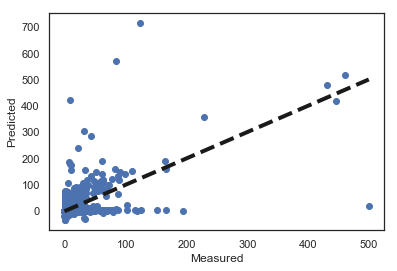

In [38]:
fig, ax = plt.subplots()
ax.scatter(Y_test, Y_pred)
ax.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured');
ax.set_ylabel('Predicted');
plt.show();

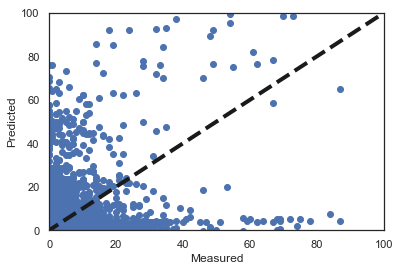

In [39]:
fig, ax = plt.subplots()
ax.scatter(Y_test, Y_pred)
ax.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=4)
ax.set_ylim(0,100)
ax.set_xlim(0,100)
ax.set_xlabel('Measured');
ax.set_ylabel('Predicted');
plt.show();

In [40]:
from sklearn.metrics import mean_squared_error
from math import sqrt
sqrt(mean_squared_error(Y_test, Y_pred))

3.366111653895069

## Model evaluations features and shap

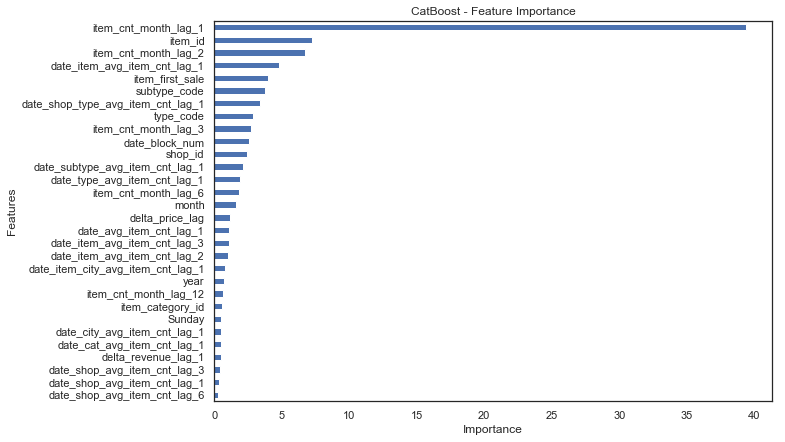

In [54]:
fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance');

In [61]:
shap_values = model.get_feature_importance(Pool(X_train
                                                , y_train
                                               ,cat_features=categorical_features_indices)
                                               , type='ShapValues')

expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]
# slicing shap because whole dataset is too much to handle
shap_valueshead = shap_values[:100000 , :]
X_trainhead = X_train.head(100000)

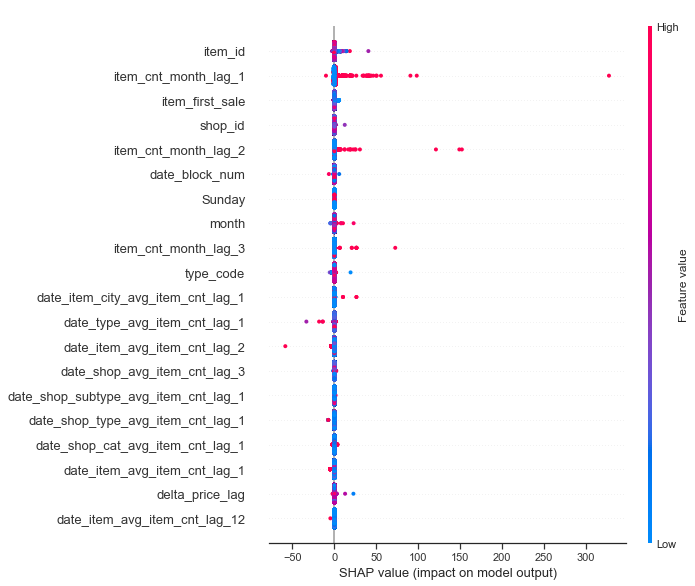

In [113]:
# summarize the effects of all the features
shap.summary_plot(shap_valueshead, X_trainhead)

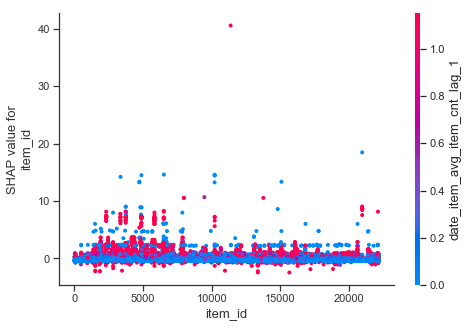

In [114]:
shap.dependence_plot("item_id", shap_valueshead, X_trainhead)

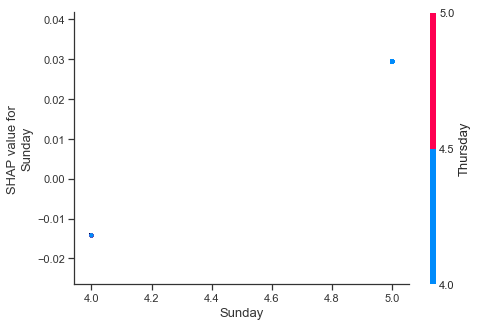

In [115]:

shap.dependence_plot("Sunday", shap_valueshead, X_trainhead)

# Multi Layer Perceptron Model

## Load Data

In [5]:
if LoadPrepData == True:
    df = pd.read_pickle('data.pkl')
    gc.collect();
else:
    print("LoadInitialData == False or SaveData == False")
df['delta_revenue_lag_1'][np.isnan(df['delta_revenue_lag_1'])] = 0
df = df.drop(['ID'], axis=1)

75

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Prepare Data for Neural Network

Label all the data by types : Reference, Categorical and Countinuous

In [6]:
#get list of categories
categorical = ['item_category_id'
               ,'city_code'
               ,'type_code'
               ,'subtype_code'
               ,'month'
               ,'year'
               ,'Monday'
               ,'Tuesday'
               ,'Wednesday'
               ,'Thursday'
               ,'Friday'
               ,'Saturday'
               ,'Sunday']
reference = ['date_block_num', 'shop_id', 'item_id']
target = ['item_cnt_month']
continuous =  [x for x in df.columns if x not in categorical]
continuous = [x for x in continuous if x not in reference]
continuous = [x for x in continuous if x not in target]
reference
categorical
continuous

['date_block_num', 'shop_id', 'item_id']

['item_category_id',
 'city_code',
 'type_code',
 'subtype_code',
 'month',
 'year',
 'Monday',
 'Tuesday',
 'Wednesday',
 'Thursday',
 'Friday',
 'Saturday',
 'Sunday']

['item_cnt_month_lag_1',
 'item_cnt_month_lag_2',
 'item_cnt_month_lag_3',
 'item_cnt_month_lag_6',
 'item_cnt_month_lag_12',
 'date_avg_item_cnt_lag_1',
 'date_item_avg_item_cnt_lag_1',
 'date_item_avg_item_cnt_lag_2',
 'date_item_avg_item_cnt_lag_3',
 'date_item_avg_item_cnt_lag_6',
 'date_item_avg_item_cnt_lag_12',
 'date_shop_avg_item_cnt_lag_1',
 'date_shop_avg_item_cnt_lag_2',
 'date_shop_avg_item_cnt_lag_3',
 'date_shop_avg_item_cnt_lag_6',
 'date_shop_avg_item_cnt_lag_12',
 'date_cat_avg_item_cnt_lag_1',
 'date_shop_cat_avg_item_cnt_lag_1',
 'date_shop_type_avg_item_cnt_lag_1',
 'date_shop_subtype_avg_item_cnt_lag_1',
 'date_city_avg_item_cnt_lag_1',
 'date_item_city_avg_item_cnt_lag_1',
 'date_type_avg_item_cnt_lag_1',
 'date_subtype_avg_item_cnt_lag_1',
 'delta_price_lag',
 'delta_revenue_lag_1',
 'daysinmonth',
 'item_shop_last_sale',
 'item_last_sale',
 'item_shop_first_sale',
 'item_first_sale']

In [7]:
def process_house_attributes(df, train, test):
    # performin min-max scaling each continuous feature column to
    cs = MinMaxScaler()
    trainContinuous = cs.fit_transform(train[continuous])
    testContinuous = cs.transform(test[continuous])

    trainCategorical = pd.get_dummies(train, columns=categorical)
    testCategorical = pd.get_dummies(test, columns=categorical)

    trainX = np.hstack([trainCategorical, trainContinuous])
    testX = np.hstack([testCategorical, testContinuous])

    return (trainX, testX)

In [8]:
split = train_test_split(df,test_size=0.25, random_state=42)
(trainAttrX, testAttrX) = split

trainAttrX.head()
testAttrX.head()

TrainY = trainAttrX['item_cnt_month']
testY= testAttrX['item_cnt_month']

(trainAttrX, testAttrX) = process_house_attributes(df,trainAttrX, testAttrX)

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale
2641115,6,55,19148,0.0,7,37,11,1,0.0,0.0,...,5,5,4,4,4,4,-1,-1,1,1
6723166,18,26,1128,0.0,13,58,13,27,0.0,0.0,...,5,5,5,4,4,4,-1,-1,18,18
10923807,34,4,13168,0.0,2,43,12,21,0.0,0.0,...,4,4,4,4,4,5,-1,-1,31,31
4114214,11,24,13427,0.0,13,14,4,14,0.0,0.0,...,5,4,4,4,4,5,-1,-1,3,3
1034554,2,26,3112,0.0,13,40,11,4,0.0,0.0,...,4,4,4,5,5,5,-1,-1,2,2


,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale
4414012,11,3,20288,0.0,1,55,13,2,0.0,0.0,...,5,4,4,4,4,5,1,-1,11,11
10777120,33,47,20656,0.0,22,72,14,59,0.0,0.0,...,4,4,5,5,5,4,1,-1,26,26
7450772,20,55,8449,0.0,7,6,1,16,0.0,0.0,...,5,4,4,4,4,4,-1,-1,6,6
464589,1,46,10134,0.0,21,55,13,2,0.0,0.0,...,4,4,4,4,4,4,-1,-1,0,0
8834654,25,58,11899,0.0,29,40,11,4,0.0,1.0,...,4,4,4,4,4,4,1,-1,25,25


/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int8, int64, float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [9]:
TrainY.shape
testY.shape

(8346003,)

(2782001,)

## Run MLP

In [10]:
# import the necessary packages
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
 
def create_mlp(dim, regress=False):
    # define our MLP network
    model = Sequential()
    model.add(Dense(4, input_dim=dim, activation="relu"))
    model.add(Dense(2, activation="relu"))
 
    # check to see if the regression node should be added
    if regress:
        model.add(Dense(1, activation="linear"))
 
    # return our model
    return model

In [11]:
mlp = create_mlp(trainAttrX.shape[1], regress=True)

from keras.optimizers import Adam
opt = Adam(lr=1e-3, decay=1e-3 / 200)
mlp.compile(loss="mean_absolute_percentage_error", optimizer=opt)
mlp.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4)                 1180      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3         
Total params: 1,193
Trainable params: 1,193
Non-trainable params: 0
_________________________________________________________________


In [12]:
len(trainAttrX)

8346003

In [13]:
# This function computes the factor of the argument passed and gives you the batch possibilities
# Its prefereable to respect it but not mandatory, if you do not use a factor the last batch will simply be smaller
# which is fine if you have many batches
def print_factors(x):
   print("the trainset can be divided by ( recommended batch length)",x,"are:")
   for i in range(1, x + 1):
       if x % i == 0:
           print(i)
print_factors(len(trainAttrX))

the trainset can be divided by ( recommended batch length) 8346003 are:
1
3
2782001
8346003


In [15]:
# you can use early stopping or to order the model to stop early or to plot live the loss functions

from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

history = mlp.fit(trainAttrX, TrainY,
          validation_data=(testAttrX, testY),
          epochs=2, batch_size=1000, callbacks=[es])


Instructions for updating:
Use tf.cast instead.
Train on 8346003 samples, validate on 2782001 samples
Epoch 1/2
8346003/8346003 [==============================] - 7362s 882us/step - loss: 89814.5673 - val_loss: 21213.9990


NameError: name 'clear_output' is not defined

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [44]:
# save the model to disk
#filename = 'mlp2.sav'
#pickle.dump(mlp, open(filename, 'wb'), protocol=4)

In [50]:
#mlp = pickle.load(open('mlp2.sav', 'rb'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [51]:
Y_pred = mlp.predict(testAttrX)
print('the length of the test ( items per shops is '+str(len(Y_pred)))

the length of the test ( items per shops is 2782001


## Model Evaluation

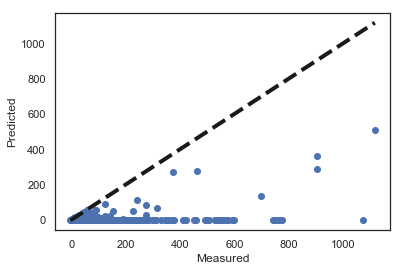

In [47]:
fig, ax = plt.subplots()
ax.scatter(testY, Y_pred)
ax.plot([testY.min(), testY.max()], [testY.min(), testY.max()], 'k--', lw=4)
ax.set_xlabel('Measured');
ax.set_ylabel('Predicted');
plt.show();

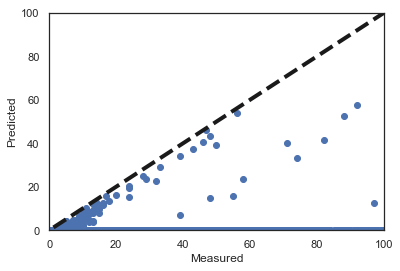

In [48]:
fig, ax = plt.subplots()
ax.scatter(testY, Y_pred)
ax.plot([testY.min(), testY.max()], [testY.min(), testY.max()], 'k--', lw=4)
ax.set_ylim(0,100)
ax.set_xlim(0,100)
ax.set_xlabel('Measured');
ax.set_ylabel('Predicted');
plt.show();

In [49]:
from sklearn.metrics import mean_squared_error
from math import sqrt
sqrt(mean_squared_error(testY, Y_pred))

2.970619335911554

# Conclusions